

Continuing down our [summarization path](https://ai-guide.future.mozilla.org/content/choosing-ml-models/#first-steps-with-language-models) -- one way we can potentially improve the quality of our summaries is to use a large language model (LLM). These models are primarily text completion models that are trained on substantially larger number of parameters (in the Billions).

Interestingly, large language models are also able to generate grammatically precise copy from scratch in various styles with enough simulated coherent "reasoning" that the outputs are very comparable to professional human writers. They can be used to not just summarize but also create new blobs of text that sound and read sane to humans.

They typically exhibit above average performance in most text-based tasks, but come with their own challenges.

#### Challenge: Expensive compute requirements
For one, they are not cheap to run. They need significant amounts of GPU power, in the form of VRAM. GPU cards available to consumers typically max out at 8GB or 16B, and in most cases 16GB cards are the bare minimum to do inference without loss for large language models.

It *is* possible to reduce the memory requirements and improve the number of devices models can run on using techniques like [quantization](https://huggingface.co/docs/optimum/concept_guides/quantization). However, these do come at a cost of reduced accuracy.

There have been [recent efforts](https://github.com/ggerganov/llama.cpp) to use quantization to make "smaller" (7B to 13B) models accessible across off-the-shelf laptops and desktops.


#### Challenge: Hallucinations
LLMs make things up sometimes. Since they're primarily text-generation engines, without strict prompting and sometimes fine-tuning, they can provide inaccurate results. Worse, sometimes they create new sources beyond what they were trained on and present them in a convincing enough way that it requires human analysis to disprove.

With respect to summarization, they've been known to misattribute quotes, misrepresent dates and times and sometimes generate new information that didn't exist before.


#### Challenge: Self-Consistency Issues
Extremely important for our use case, is self-consistency. This refers to the ability of a model to generate comparable and relevant results across slight variations in input text.

This characteristic varies by each model and is key to unlocking many LLM-powered behaviors in a consistent way as requirements evolve. Using summarization as an example, assuming comparable output content length -- does the quality of the summary remain roughly the same? We will be thinking through how to address this.


#### Challenge: Prompting
Unlike smaller language models, large ones have the ability to be "instructed". This takes the form of a leading "system prompt" that influences the action the LLM is being asked to take. Variations in system prompt sometimes lead to substantial changes in output quality and length. Enough of a variable that "prompt engineers" has evolved to be a new role that didn't existing pre-LLM.


#### Additional inference variables
[Temperature](https://ai-guide.future.mozilla.org/content/llms-101/#what-is-temperature), [top_p](https://ai-guide.future.mozilla.org/content/llms-101/#what-is-top_p-sampling), [top_k](https://ai-guide.future.mozilla.org/content/llms-101/#what-is-top_k-sampling) and similar variables can also affect the consistency of the output.

In conclusion -- all this being said, using LLMs for various tasks is a decision that should be made with the tradeoffs above in mind. The best way to evaluate the tradeoffs is with numbers, so let's take a stab at that.

## Inference using LLMs

Let's bring back our original and reference examples from the [Choosing Language Models](https://ai-guide.future.mozilla.org/content/choosing-ml-models/) section and test out summarization using a LLM.

In [1]:
content = """Mozilla's "Trustworthy AI" Thinking Points:

PRIVACY: How is data collected, stored, and shared? Our personal data powers everything from traffic maps to targeted advertising. Trustworthy AI should enable people to decide how their data is used and what decisions are made with it.

FAIRNESS: We’ve seen time and again how bias shows up in computational models, data, and frameworks behind automated decision making. The values and goals of a system should be power aware and seek to minimize harm. Further, AI systems that depend on human workers should protect people from exploitation and overwork.

TRUST: People should have agency and control over their data and algorithmic outputs, especially considering the high stakes for individuals and societies. For instance, when online recommendation systems push people towards extreme, misleading content, potentially misinforming or radicalizing them.

SAFETY: AI systems can carry high risk for exploitation by bad actors. Developers need to implement strong measures to protect our data and personal security. Further, excessive energy consumption and extraction of natural resources for computing and machine learning accelerates the climate crisis.

TRANSPARENCY: Automated decisions can have huge personal impacts, yet the reasons for decisions are often opaque. We need to mandate transparency so that we can fully understand these systems and their potential for harm."""
print("ORIGINAL: ")
print(content)
print("--------")
reference_summary = "Mozilla's 'Trustworthy AI' is built on five key principles. Privacy emphasizes user control over data collection and usage. Fairness focuses on minimizing bias in computational models, as well as protecting human workers from exploitation. Trust aims to provide individuals with control over their data and the decisions made by algorithms. Safety prioritizes protection against misuse of data, as well as reducing environmental impact. Lastly, Transparency mandates clarity in automated decision-making processes to prevent potential harm."
print("REFERENCE: ")
print(reference_summary)


ORIGINAL: 
Mozilla's "Trustworthy AI" Thinking Points:

PRIVACY: How is data collected, stored, and shared? Our personal data powers everything from traffic maps to targeted advertising. Trustworthy AI should enable people to decide how their data is used and what decisions are made with it.

FAIRNESS: We’ve seen time and again how bias shows up in computational models, data, and frameworks behind automated decision making. The values and goals of a system should be power aware and seek to minimize harm. Further, AI systems that depend on human workers should protect people from exploitation and overwork.

TRUST: People should have agency and control over their data and algorithmic outputs, especially considering the high stakes for individuals and societies. For instance, when online recommendation systems push people towards extreme, misleading content, potentially misinforming or radicalizing them.

SAFETY: AI systems can carry high risk for exploitation by bad actors. Developers ne

Let's load up Mistral-7B again, this time using Huggingface's Transformers library.

If you're on Colab, **change your runtime to a T4 GPU**. Otherwise, you'll need roughly 16GB to run this model.

In [ ]:
# next 2 lines are to prevent some Colab errors
import locale
locale.getpreferredencoding = lambda: "UTF-8"

import os
running_inside_colab = False
if os.getenv("COLAB_RELEASE_TAG"):
    print("Running inside Colab")
    running_inside_colab = True
else:
    print("Not running inside Colab")


%pip install transformers accelerate bitsandbytes peft numpy
%pip install --upgrade numexpr h5py matplotlib

Next, we're going to load the 4-bit quantized version of the Mistral-7B model. This will require just enough RAM that we can run it on a Colab, at the expense of model performance. We'll be pulling down over 13GB of data - a big difference from the smaller models we used in the previous sections.

Colab users, here's a tip:
If you're on the free Colab, it's possible to run 7B models sometimes by using a "sharded" version of the model which splits each model `.bin` file into smaller sizes, loads and discards.

In [52]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "mistralai/Mistral-7B-Instruct-v0.1"
if running_inside_colab:
    # if you're using free Colab, load sharded version to stay within memory limits
    model_id = "filipealmeida/Mistral-7B-Instruct-v0.1-sharded" # thank you, @filipealmedia

# Let's set the seed so we get consistent results during inference
def set_seed(seed):
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(50621921)

bnb_config = None
if running_inside_colab:
    # load the 4-bit quantized if running inside Colab
    bnb_config = BitsAndBytesConfig(
        load_in_4bit=True,
        bnb_4bit_use_double_quant=True,
        bnb_4bit_quant_type="nf4",
        bnb_4bit_compute_dtype=torch.bfloat16
    )

model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map="auto", torch_dtype="auto")
tokenizer = AutoTokenizer.from_pretrained(model_id, padding_side="left")
tokenizer.pad_token = tokenizer.eos_token

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Alright, now let's give the summarization a shot with a simple instruction. We'll have to point the model towards the GPU while we do it.

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

prompt = f"""<s>[INST]Summarize: {content}[/INST]"""
all_prompts = [prompt]

encoded_tokens = tokenizer(prompt, return_tensors="pt", add_special_tokens=False, padding=True)

model_input = encoded_tokens.to(device)

generated_token_ids = model.generate(**model_input, max_new_tokens=500, do_sample=True, temperature=0.5, pad_token_id=tokenizer.eos_token_id)

decoded_tokens = tokenizer.batch_decode(generated_token_ids)

In [5]:
def get_final_response(decoded_tokens):
    return decoded_tokens[0].split('[/INST] ')[1].replace("</s>", "")

mistral_summary = get_final_response(decoded_tokens)
print(mistral_summary)
print(len(mistral_summary))

Mozilla's "Trustworthy AI" thinking points emphasize the importance of privacy, fairness, trust, safety, and transparency in the development and use of artificial intelligence. Privacy should be respected and people should have control over their data and algorithmic outputs. AI systems should be designed to minimize harm and protect people from exploitation and overwork. Safety measures should be implemented to protect against exploitation by bad actors and excessive energy consumption should be addressed to mitigate the climate crisis. Transparency is necessary to understand the potential impacts of automated decisions and prevent harm.
646


Not bad! Let's see BERTScore for this one.

In [ ]:
%pip install bert_score

In [ ]:
from bert_score import BERTScorer
bert_scorer = BERTScorer(lang="en", rescale_with_baseline=True)

In [8]:
p, r, f1 = bert_scorer.score([mistral_summary], [reference_summary])
print(f"Mistral-7B-Instruct BERTScore: 'r': {r}, 'p': {p}, 'f': {f1}")

Mistral-7B-Instruct BERTScore: 'r': tensor([0.4152]), 'p': tensor([0.3656]), 'f': tensor([0.3913])


This is a  higher score than the 32 from the BART model from the 'Choosing a language model' section and instantly shows the extent of which a "zero-shot" (no examples provided) large language model can instantly generate better results than smaller, summarization-focused ones.

## Prompt Engineering
Let's try a bunch of different prompts to see if the summary improves.

In [53]:
def generate_result_for_prompt(p, temperature=0.5, max_new_tokens=500, **kwargs):
    print(f"Generating for prompt: {p[:50]}")
    model_inputs = tokenizer(p.format(content), return_tensors="pt", add_special_tokens=False, padding=True).to(device)
    generated_ids = model.generate(**model_inputs, temperature=temperature, max_new_tokens=max_new_tokens, do_sample=True, pad_token_id=tokenizer.eos_token_id, **kwargs)
    decoded_tokens = tokenizer.batch_decode(generated_ids)
    return get_final_response(decoded_tokens)

new_prompts = [
    "<s>[INST]Summarize in granular detail: {}[/INST]",
    "<s>[INST]Write a detailed summary, not missing any parts, limit 400 chars: {}[/INST]",
    "<s>[INST]Summarize with minimized characters, without information loss: {}[/INST]"
]
all_prompts.extend(new_prompts)

results = []
for p in new_prompts:
    results.append(generate_result_for_prompt(p, temperature=0.5))

Generating for prompt: <s>[INST]Summarize in granular detail: {}[/INST]
Generating for prompt: <s>[INST]Write a detailed summary, not missing any
Generating for prompt: <s>[INST]Summarize with minimized characters, with


In [54]:
import pandas as pd
pd.set_option('display.max_columns', None)  # show all cols
pd.set_option('display.expand_frame_repr', False)  # don't wrap to multiple pages
pd.set_option('display.max_colwidth', None)  # show full text

from IPython.display import display

def compare(prompts, results, temperature=0.5):
    if len(prompts) != len(results):
        raise ValueError("Prompts & Results aren't the same length")
    compare_list = [[
        prompts[i], 
        float(bert_scorer.score([result], [reference_summary])[2])*100, 
        temperature,
        len(result),
        result
    ] for i, result in enumerate(results)]
    df = pd.DataFrame(compare_list, columns=["Prompt", "BERTScore f-value", "Temperature", "Length (chars)", "Summary (Mistral-7B-Instruct)"])
    return df

display(compare(new_prompts, results))

,Prompt,BERTScore f-value,Temperature,Length (chars),Summary (Mistral-7B-Instruct)
0,<s>[INST]Summarize in granular detail: {}[/INST],28.296643,0.5,1712,"Mozilla's ""Trustworthy AI"" thinking points are centered around four main areas: privacy, fairness, trust, safety, and transparency.\n\nPrivacy refers to how data is collected, stored, and shared. Trustworthy AI should give individuals control over their data and enable them to decide how it is used. This includes ensuring that AI systems do not misuse or exploit personal data, and that individuals can easily delete or modify their data as needed.\n\nFairness is another important consideration. Bias can show up in computational models, data, and frameworks behind automated decision making. Trustworthy AI should aim to minimize harm and protect people from exploitation, especially when it comes to human workers.\n\nTrust is also a key aspect of Mozilla's thinking points. People should have agency and control over their data and algorithmic outputs, especially in cases where the stakes are high for individuals and societies. This includes preventing AI systems from pushing individuals towards extreme or misleading content.\n\nSafety is another important consideration. AI systems can carry high risks for exploitation by bad actors, and developers need to implement strong measures to protect personal data and personal security. This includes addressing the climate crisis by reducing energy consumption and resource extraction for computing and machine learning.\n\nFinally, transparency is essential for understanding the potential impact of automated decisions. We need to mandate transparency so that we can fully understand these systems and their potential for harm. This includes making it easier for individuals to understand how their data is being used and the reasoning behind automated decisions."
1,"<s>[INST]Write a detailed summary, not missing any parts, limit 400 chars: {}[/INST]",37.271866,0.5,492,"Mozilla's ""Trustworthy AI"" Thinking Points:\n\n* Privacy: AI should respect individuals' control over their data and decisions made with it.\n* Fairness: AI should minimize harm and avoid bias in decision making.\n* Trust: People should have agency and control over data and algorithmic outputs.\n* Safety: AI systems should be protected from exploitation by bad actors and excessive energy consumption.\n* Transparency: Automated decisions should be transparent to understand their potential harm."
2,"<s>[INST]Summarize with minimized characters, without information loss: {}[/INST]",19.317041,0.5,95,"Mozilla's ""Trustworthy AI"" Thinking Points: Privacy, Fairness, Trust, Safety, and Transparency."


There's substantial variance between these f-scores, which proves out the prompt-sensitivity we mentioned earlier as a challenge. Worse, if we switch to another model that's not Mistral-7B, it may not generate high quality summaries with the same prompts. Let's try a few more prompts to see if we can nudge this score higher.

In [12]:
more_prompts = [
    "<s>[INST]5 lines summarizing key points {}[/INST]",
    "<s>[INST]Summarize this text as part of an executive briefing: {}[/INST]",
    "<s>[INST]Thorough summary of the following: {}[/INST]"
]
all_prompts.extend(more_prompts)

results = []
for p in more_prompts:
    results.append(generate_result_for_prompt(p, temperature=0.5))

display(compare(more_prompts, results))

Generating for prompt: <s>[INST]5 lines summarizing key points {}[/INST]
Generating for prompt: <s>[INST]Summarize this text as part of an executi
Generating for prompt: <s>[INST]Thorough summary of the following: {}[/IN


,Prompt,BERTScore f-value,Temperature,Length (chars),Summary (Mistral-7B-Instruct)
0,<s>[INST]5 lines summarizing key points {}[/INST],40.659925,0.5,366,"Mozilla's ""Trustworthy AI"" Thinking Points emphasize the importance of privacy, fairness, trust, safety, and transparency in AI systems. These principles aim to empower individuals and communities to control their data and algorithmic outputs, minimize harm and exploitation, protect personal security, and ensure transparency in automated decision-making processes."
1,<s>[INST]Summarize this text as part of an executive briefing: {}[/INST],36.182114,0.5,592,"The Mozilla ""Trustworthy AI"" framework emphasizes the importance of privacy, fairness, trust, safety, and transparency in the development and implementation of AI systems. Privacy should be respected, and individuals should have control over their data and algorithmic outputs. AI systems should minimize harm and protect people from exploitation and overwork. AI systems should also be designed to be safe and secure from exploitation by bad actors. Transparency is also critical to ensure that the reasons for automated decisions are understandable and that these systems do not cause harm."
2,<s>[INST]Thorough summary of the following: {}[/INST],20.970829,0.5,1926,"Mozilla's ""Trustworthy AI"" Thinking Points are a set of guidelines for building AI systems that prioritize privacy, fairness, trust, safety, and transparency. These principles are designed to ensure that AI systems are designed and implemented in a way that minimizes harm and maximizes the benefits for individuals and society as a whole.\n\nPrivacy is a key consideration, as personal data powers many AI systems and can be used for a range of purposes, from targeted advertising to traffic maps. Trustworthy AI should enable people to have control over their data and make decisions about how it is used and what decisions are made with it.\n\nFairness is also a critical component of trustworthy AI. Bias can show up in computational models, data, and frameworks behind automated decision making, and it is important for AI systems to be designed with values and goals that minimize harm. Additionally, AI systems that depend on human workers should protect people from exploitation and overwork.\n\nTrust is another key consideration, as people should have agency and control over their data and algorithmic outputs, especially given the high stakes for individuals and societies. For example, online recommendation systems can push people towards extreme, misleading content, potentially misinforming or radicalizing them.\n\nSafety is also a concern, as AI systems can carry high risk for exploitation by bad actors. Developers need to implement strong measures to protect our data and personal security. Additionally, excessive energy consumption and extraction of natural resources for computing and machine learning accelerates the climate crisis.\n\nFinally, transparency is essential for building trustworthy AI. Automated decisions can have huge personal impacts, yet the reasons for decisions are often opaque. Mandating transparency can help ensure that we can fully understand these systems and their potential for harm."


<!-- Better! Let's try a prompting technique called "Chain-of-Thought" (CoT) which essentially asks the model to think step by step. We'll use the learnings from two high-performing prompts earlier to kick off this process. -->

Prompt engineering is a complex topic, and has thorough guides [written elsewhere](https://developers.google.com/machine-learning/resources/prompt-eng). We recommend you learn the basics to improve this f-score and your output further just by fiddling with prompts, which is currently the highest leverage work you can do with LLMs. For now, let's pick the best combined prompt we've seen so far.

In [13]:
final_prompt = ["""<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]"""]
all_prompts.extend(final_prompt)

results = []
for p in final_prompt:
    results.append(generate_result_for_prompt(p, temperature=0.5))

display(compare(final_prompt, results, temperature=0.5))

Generating for prompt: <s>[INST]Summarize the text below for an executive


,Prompt,BERTScore f-value,Temperature,Length (chars),Summary (Mistral-7B-Instruct)
0,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",29.82792,0.5,264,"Mozilla outlines their ""Trustworthy AI"" principles, including privacy, fairness, trust, safety, and transparency. AI systems should respect user privacy, minimize bias and harm, ensure user control, protect against risks and exploitation, and promote transparency."


## LLM Temperature

The `temperature` variable controls the variability of the text generated by the model. The default `0.5` we're using is right in the middle - closer to `1.0` and we get atypical text and beyond we may get hallucinations, non-sequiturs and sometimes glimpses of the training data (especially with smaller B models). Setting temperature near `0` will reduce this behavior. Let's explore a few temperature points with our winning prompt.

In [ ]:
temperatures = [0.01, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 2.0, 2.5, 3.0]
temperature_prompts = final_prompt*len(temperatures)

results = []
for i, p in enumerate(temperature_prompts):
    results.append(generate_result_for_prompt(p, temperature=temperatures[i]))

In [15]:
dfs = compare(temperature_prompts, results)
dfs['Temperature'] = temperatures
display(dfs)

# lets get the standard deviation
stdev = dfs["BERTScore f-value"].std()
print(f"Standard Deviation: {stdev}")

,Prompt,BERTScore f-value,Temperature,Length (chars),Summary (Mistral-7B-Instruct)
0,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",38.529971,0.01,291,"Mozilla's ""Trustworthy AI"" includes privacy, fairness, trust, safety, and transparency. Developers should protect personal data, minimize bias, ensure people have control over their data and algorithmic outputs, protect against exploitation, and mandate transparency for automated decisions."
1,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",39.352167,0.25,332,"Mozilla's ""Trustworthy AI"" focuses on privacy, fairness, trust, safety, and transparency. Developers should prioritize protecting personal data, minimizing bias, ensuring people have control over their data and algorithmic outputs, safeguarding against exploitation by bad actors, and mandating transparency for automated decisions."
2,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",34.913415,0.50,281,"Mozilla's ""Trustworthy AI"" highlights the importance of privacy, fairness, trust, safety, and transparency in AI systems. Developers must implement strong measures to protect personal data and security, minimize harm, and ensure transparency in automated decision-making processes."
3,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",38.327679,0.75,417,"Mozilla's ""Trustworthy AI"" Thinking Points: Privacy, Fairness, Trust, Safety, and Transparency. Developers need to protect personal data, minimize harm, and enable people to control their data and algorithmic outputs. Strong measures must be implemented to protect against exploitation by bad actors and excessive energy consumption. Transparency is crucial to understand the potential impacts of automated decisions."
4,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",38.769096,1.00,189,"Mozilla's ""Trustworthy AI"" proposes principles for privacy, fairness, trust, safety, and transparency in AI to ensure individuals have control over their data and decision-making processes."
5,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",29.482561,1.25,405,"Mozilla's Trustworthy AI: Privacy, Fairness, Trust, Safety, and Transparency. AI systems should enable data collection and usage decisions, mitigate bias, ensure human control over data and algorithmic outputs, protect against data theft and safety risks, and provide transparency in decision-making reasoning. AI developers should address the high stakes and climate crisis implications of their systems."
6,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",36.410856,1.50,554,"Mozilla outlines its “Trustworthy AI” Framework in four areas: Privacy, Fairness, Trust, Safety, and Transparency. Privacy means people should have control over their data, Fairness emphasizes the importance of freeing technology from bias, Trust centers on people needing agency over their data vs algorithmic outputs, Safety requires developers to protect personal security and excessive use mitigate the environmental impact, including of the current climate crisis, while Transparency ensures AI systems and decisions can have less impact on society."
7,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",6.521630,2.00,160,"Mozilla's AI principles suggest Trustful methods to establish human and algorithm agreement in matters of privacy, authentic implicity biasness. and safeprotecs"
8,"<s>[INST]Summarize the text below for an executive, with minimized characters, without information loss: {}[/INST]",7.133165,2.50,397,"Privacy and t

Standard Deviation: 15.438810246636642


The standard deviation between BERTScores between these temperatures are high as expected. Sweet spot seems to be a `temperature` between `0` and `0.8`. Clearly past temperature `1.25` it's mostly nonsense.

## Self-Consistency
One of the challenges working with LLMs is their non-deterministic nature. To illustrate, let's do 10 runs for each temperature between `0` and `0.8` in `0.1` increments with the same prompt to get a sense for standard deviation of f-value for each temperature - the lower the stdev the better. Note, this might take a long while on a free Colab.

What we're looking for is whether the same prompt, with the same variables winds up giving us wildly different BERTScore f-values. If this is the case, then self-consistency is an issue at that particular temperature. If most temperatures wind up having high standard deviations, then the model itself is not self-consistent for this particular task scope, and we should really be exploring either larger models, different models or a different approach. 

In [ ]:
iterations = list(range(21))
temperatures = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

result_hash = {}
for temp in temperatures:
    print(f"> for temperature {temp}")
    result_hash[temp] = []
    for i in iterations:
        result_hash[temp].append(generate_result_for_prompt(final_prompt[0], temperature=temp))

In [60]:
stdevs = []
iteration_count = len(iterations)
for temp in temperatures:
    df = compare([final_prompt]*iteration_count, result_hash[temp])
    df["Temperature"] = temp
    stdevs.append(
        [
            temp, 
            df["BERTScore f-value"].std(),
            df["BERTScore f-value"].var(),
            df["BERTScore f-value"].max(),
            df["BERTScore f-value"].min(),
            df["BERTScore f-value"].mean()
        ]
    )

stdevs_df = pd.DataFrame(stdevs, columns=["Temperature", "f-value stdev", "Variance", "Max", "Min", "Mean"])
display(stdevs_df)

print(f"Mean stdev: {stdevs_df['f-value stdev'].mean()}")

,Temperature,f-value stdev,Variance,Max,Min,Mean
0,0.01,0.000000,0.000000,38.529971,38.529971,38.529971
1,0.10,2.670393,7.130998,39.538142,27.095997,37.603446
2,0.20,4.688875,21.985550,41.250837,19.317041,35.063552
3,0.30,3.686930,13.593454,41.716620,25.973225,35.269734
4,0.40,6.286330,39.517945,45.562521,19.317041,34.785367
5,0.50,5.027804,25.278812,41.301408,18.407296,36.086037
6,0.60,3.625654,13.145366,43.355256,27.875358,35.324442
7,0.70,4.717840,22.258015,41.833094,25.341561,35.242033
8,0.80,5.263416,27.703550,42.830566,24.894705,34.556057


Mean stdev: 3.9963602293765543


Rough, the mean standard deviation is higher than we'd like across the entire temperature spectrum. Time to check out other models.

## Larger Model Evals
Note: The section below will *not* work on free Colab due to resource limits. The code below was run on an 8x A100 machine.

Let's see what happens when we run the same prompt and f-score calculations on a larger model: `Yi-34B` 

In [ ]:
model_path = '01-ai/Yi-34b-Chat'

tokenizer = AutoTokenizer.from_pretrained(model_path, use_fast=False)

model = AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map="auto",
    torch_dtype='auto'
).eval()

In [20]:
def yi34_generate_result_for_prompt(p, temperature=0.5, max_new_tokens=500, **kwargs):
    print(f"Generating for prompt: {p[:50]}")
    messages = [
        {"role": "system", "content": "You are the best summarizer in the world."},
        {"role": "user", "content": f"{p}: {content}"}
    ]
    input_ids = tokenizer.apply_chat_template(conversation=messages, tokenize=True, add_generation_prompt=True, return_tensors='pt')
    output_ids = model.generate(input_ids.to(device), temperature=temperature, max_new_tokens=max_new_tokens)
    response = tokenizer.decode(output_ids[0][input_ids.shape[1]:], skip_special_tokens=True)
    return response

print(yi34_generate_result_for_prompt("Summarize"))

Generating for prompt: Summarize
Mozilla's "Trustworthy AI" Thinking Points:

1. Privacy: Data collection, storage, and sharing should be transparent and respect user control.

2. Fairness: AI systems should be designed to minimize bias and ensure that the values and goals of the system are inclusive and do not cause harm.

3. Trust: Individuals should have control over their data and the ability to understand and trust the decisions made by AI systems.

4. Safety: AI systems should be secure from exploitation and consider the environmental impact of their energy consumption and resource use.

5. Transparency: AI decisions should be transparent, allowing for scrutiny and understanding of their potential impact and harm.


Working! Now, let's run our f-value stdev by temperature work here again -- 10 samples per temperature for the best performing prompt from last time.
Note: This will take many tens of minutes even on hefty machines with > 40GB VRAM.

In [ ]:
iterations = list(range(11))
temperatures = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

result_hash_yi = {}
for temp in temperatures:
    print(f"> for temperature {temp}")
    result_hash_yi[temp] = []
    for i in iterations:
        result_hash_yi[temp].append(yi34_generate_result_for_prompt(final_prompt[0], temperature=temp))

In [42]:
stdevs_yi = []
for temp in temperatures:
    df = compare([final_prompt]*len(iterations), result_hash_yi[temp])
    df["Temperature"] = temp
    stdevs_yi.append(
        [
            temp, 
            df["BERTScore f-value"].std(),
            df["BERTScore f-value"].var(),
            df["BERTScore f-value"].max(),
            df["BERTScore f-value"].min(),
            df["BERTScore f-value"].mean()
        ]
    )

stdevs_yi_df = pd.DataFrame(stdevs_yi, columns=["Temperature", "f-value stdev", "Variance", "Max", "Min", "Mean"])
display(stdevs_yi_df)
print(f"Mean stdev: {stdevs_yi_df['f-value stdev'].mean()}")

,Temperature,f-value stdev,Variance,Max,Min,Mean
0,0.01,0.216285,0.046779,42.153412,41.739258,41.927510
1,0.10,0.821504,0.674869,43.884116,40.793422,41.991083
2,0.20,1.358719,1.846118,44.709527,40.211764,42.287360
3,0.30,3.122985,9.753035,43.884116,34.024543,37.027070
4,0.40,4.189997,17.556075,42.642048,30.764291,36.946328
5,0.50,5.530519,30.586635,43.884116,26.147157,36.945290
6,0.60,5.564940,30.968559,43.305251,25.812784,34.117716
7,0.70,3.223112,10.388454,41.692254,29.688489,34.806488
8,0.80,3.720446,13.841716,43.070468,31.229725,35.817266


Mean stdev: 3.0831674527387922


#### Comparing models

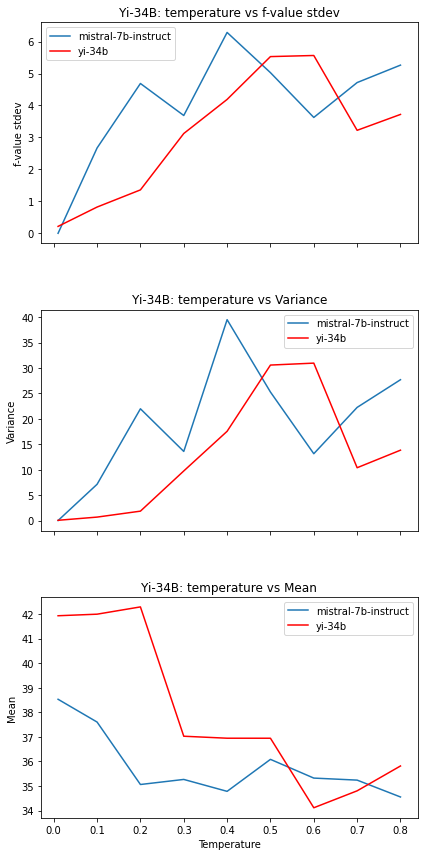

In [99]:
# plotting both models together
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6,12), sharex=True, sharey='row')

fields = ["f-value stdev", "Variance", "Mean"]

for i, field in enumerate(fields):
    stdevs_df.plot(x='Temperature', y=field, ax=axes[i], label="mistral-7b-instruct")
    stdevs_yi_df.plot(x='Temperature', y=field, ax=axes[i], color="red", label="yi-34b")
    
    # # set titles for subplots
    axes[i].set_title(f'Mistral-7B-Instruct: temperature vs {field}')
    axes[i].set_title(f'Yi-34B: temperature vs {field}')
    
    # set y-labels for subplots
    axes[i].set_ylabel(field)
    axes[i].set_ylabel(field)

plt.tight_layout()
plt.subplots_adjust(hspace=0.3)

plt.show()

The difference between both models is clear with the charts above. For sub-`0.5` temperatures:
- The standard deviation of the f-value is lower in the 34B model.
- The variance (square of the standard deviation and a measure of spread) is lower in the 34B model.
- The average f-value is generally higher with the 34B model.

So not only is the 34B model self-consistent while text variability increases, the output quality (as measured by BERTScore f-value) is also generally higher, sometimes by a significant margin.

However, running a 34B model is not easy. While a 7B model can fit in 5GB of RAM or VRAM, a 34B model needs atleast 24GB of VRAM, which is usually tough for consumer machines. 

Choices, choices!